# Vignette A: recursive propagation with MOON

In this vignette, we are going to use MOON:

> Dugourd et al., Modeling causal signal propagation in multi-omic factor space with COSMOS. *bioRxiv (2024)*. https://doi.org/10.1101/2024.07.15.603538

 to iteratively compute enrichment scores for a prior knowledge network, taking metabolic measurements and signalling cascades as inputs. 

This is the python version of the MOON workflow detailed in this [R vignette](https://saezlab.github.io/cosmosR/articles/NCI60_tutorial.html) within the package CosmosR. For more information, please check the [MOON section](../methods.html#moon) in the Methods details and the [original CosmosR paper](https://doi.org/10.15252/msb.20209730).


In [1]:
import networkcommons as nc
import decoupler as dc
import pandas as pd

## 1. Input preparation

We first import the COSMOS network, including signalling, gene regulatory and metabolic networks.

In [2]:
meta_network_df = nc.data.network.get_cosmos_pkn(update=True)
meta_network = nc.utils.network_from_df(meta_network_df, directed=True)

Here, we aim to remove self-interactions, calculate the mean interaction values for duplicated source-target pairs, and keep only interactions with values of 1 or -1.

In [3]:
meta_network = nc.methods.meta_network_cleanup(meta_network)

In this notebook, we will use data from the NCI60 Human Tumor Cell Lines Screen. We will use the cell line 706-0. To have an overview of the cell lines, we can run `nc.data.omics.nci60_datasets()`. For more information, please check the [NCI60 details page](../datasets.html#nci60).

In [4]:
nc.data.omics.nci60_datasets().head()

,cell_line
0,786-0
1,A498
2,A549_ATCC
3,ACHN
4,BT-549


This resource contains three different types of data: transcriptomics, TF activity estimates and metabolic information.

In [5]:
nc.data.omics.nci60_datatypes()

,data_type,description
0,TF_scores,TF scores
1,RNA,RNA expression
2,metabolomic,metabolomic data


We can get measurements for different subnetworks within the cosmos network:

In [6]:
sig_df = nc.data.omics.nci60_table(cell_line='786-0', data_type='TF_scores')
rna_df = nc.data.omics.nci60_table(cell_line='786-0', data_type='RNA')
metab_df = nc.data.omics.nci60_table(cell_line='786-0', data_type='metabolomic')

sig_input = sig_df.set_index('ID')['score'].to_dict()
rna_input = rna_df.set_index('ID')['score'].to_dict()
metab_input = metab_df.set_index('ID')['score'].to_dict()

For the metabolites, we add the compartment they are located in. We also remove those genes that do not apear in the PKN.

In [7]:
metab_input = nc.methods.prepare_metab_inputs(metab_input, ["c", "m"])

In [8]:
meta_network = nc.methods.filter_pkn_expressed_genes(rna_input.keys(), meta_network)

We filter out those inputs that cannot be mapped to the prior knowledge network.

In [9]:
sig_input = nc.methods.filter_input_nodes_not_in_pkn(sig_input, meta_network)
meta_network = nc.methods.keep_controllable_neighbours(sig_input, meta_network)
metab_input = nc.methods.filter_input_nodes_not_in_pkn(metab_input, meta_network)
meta_network = nc.methods.keep_observable_neighbours(metab_input, meta_network)
sig_input = nc.methods.filter_input_nodes_not_in_pkn(sig_input, meta_network)

## 2. Network compression

Now, we will compress the network to reduce the dimensions of the problem and thus increase computational efficiency. For more information about how this is carried out, please check the dedicated [section](../methods.html#network-compression).

In [10]:
meta_network_compressed, signatures, dup_parents = nc.methods.compress_same_children(meta_network, sig_input, metab_input) # equals R

We clean the network again in case some self loops arose.

In [11]:
meta_network_compressed = nc.methods.meta_network_cleanup(meta_network_compressed)

## 3. MOON scoring

Now it is time to compute the MOON scores from the compressed network. The network has been compressed by around a third of its original size, which increases computational efficiency. We will use the metabolic inputs and the signalling inputs to compute the MOON scores. After each optimisation, we check the sign consistency of the MOON scores, and remove those edges that turn out to be incoherent (the real TF enrichment scores are compared against the computed MOON scores and the sign of the edge). If there are incoherent edges, the function computes the MOON scores on the reduced network. The loop continues until it reaches a maximum number of tries (in our example, 10) or there are no incoherent edges left (more details [here](../methods.html#moon-scoring)).

We can get now the GRN from DoRothEA, filtering by levels of confidence A and B.

In [12]:
tf_regn = dc.get_dorothea(levels = ['A', 'B'])

In [13]:
moon_network = meta_network_compressed.copy()

In [14]:
moon_res, moon_network = nc.methods.run_moon(
    meta_network_compressed,
    sig_input,
    metab_input,
    tf_regn,
    rna_input,
    n_layers=6,
    method='ulm',
    max_iter=10)

## 4. Decompression and solution network

Once the MOON scores are computed, we need to restore the uncompressed nodes that were compressed in section 2. For this, we will use the signatures that we obtained when we compressed the network to map back the original nodes to the compressed ones. After that, we can retrieve a solution network that contains the nodes (with the subsequent MOON scores) that are in the vicinity of the signalling input(s) and are sign consistent in terms of signed interactions.

In [15]:
moon_res_dec = nc.methods.decompress_moon_result(moon_res, signatures, dup_parents, meta_network_compressed)

Now, we perform the decompression of the network, mapping the compressed nodes to their original components.

FInally, we reduce the solution network by removing incoherent edges and filtering for nodes with moon scores higher than 1. We retrieve a networkx.DiGraph that we will visualise, and an attributes dataframe with the moon scores.

In [16]:
res_network, att = nc.methods.reduce_solution_network(moon_res_dec, meta_network, 1, sig_input, rna_input) # equals R

We can visualise the 10 nodes with highest (absolute) score:

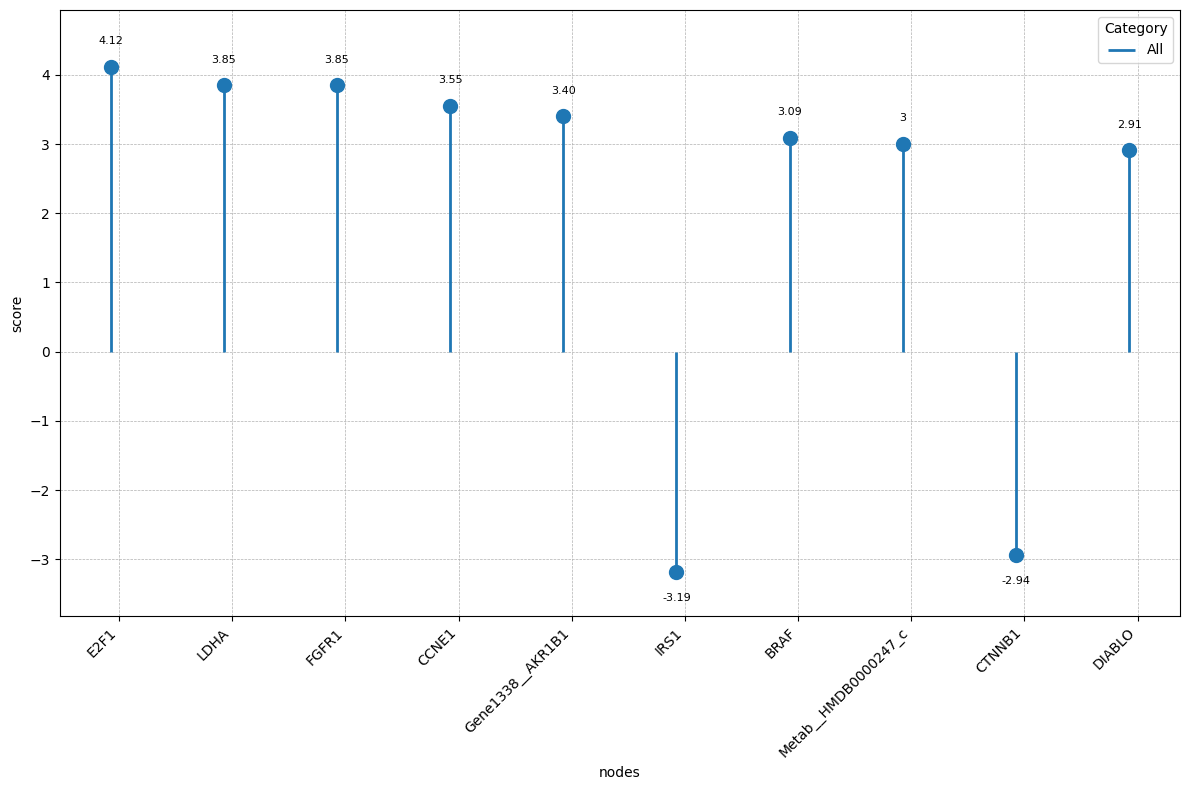

In [24]:
top_nodes = att.sort_values('score', key=lambda x: abs(x), ascending=False).head(10)
p = nc.visual.lollipop_plot(
    df=top_nodes,
    label_col='nodes',
    value_col='score',
    label_gap=0.03
)

As an optional step, we can translate the HMDB identifiers to more readable names (e.g HMDB0000122 is Glucose).

In [18]:
mapping_dict = pd.read_csv("../../../data/moon/hmdb_mapper_vec.csv", header=0).set_index('HMDB_id')['name'].to_dict()

In [19]:
translated_network, att_translated = nc.methods.translate_res(res_network, att, mapping_dict)

The resulted network can be used now for visualization purposes, or further studying of the topology can be conducted, as shown in Vignette 1. Since the network is quite big, it will not be shown in this notebook.